In [3]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


In [4]:
# helpers functions
def pair(t):
  if isinstance(t, tuple):
    return t
  return (t, t)

# Transformer Encoder || Transformer

In [5]:
class FeedForward(nn.Module):
  """  2 layer MLP with GELU activation and dropout
  dim : input and output dimension of feed forward layer
  hidden_dim : hidden dimension of feed forward layer or Intermediate layer
  dropout : optional and default is 0.
  pre-layernorm is used here

  """
  def __init__ (self, dim, hidden_dim, dropout = 0.):
    super().__init__()
    self.feedforward = nn.Sequential(
      nn.LayerNorm(dim),
      nn.Linear(dim,hidden_dim),
      nn.GELU(),
      nn.Dropout(dropout),
      nn.Linear(hidden_dim,dim),
      nn.Dropout(dropout)
    )
    print(self.feedforward)

  def forward(self, x):
    # print(self.feedforward(x))
    res = self.feedforward(x)
    return res
  
# test the class
ff = FeedForward(512, 2048)
x = torch.randn(10, 512)

out = ff(x)
print(out.shape)


Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=2048, bias=True)
  (2): GELU(approximate='none')
  (3): Dropout(p=0.0, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=True)
  (5): Dropout(p=0.0, inplace=False)
)
torch.Size([10, 512])


In [25]:

  
class Attention(nn.Module):
  """
  Multi-head self attention layer
  dim : input and output dimension of attention layer
  heads : number of heads
  dim_head : dimension of each head
  dropout : optional and default is 0.
  """
  def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
    super().__init__()
    inner_dim = dim_head * heads #512
    self.heads = heads
    print(f"self.heads {self.heads}")
    print(f"dim_head {dim_head}")
    print(f"inner_dim {inner_dim}\n\n")
    # scale is used to scale the dot product of q and k to prevent the values from getting too large
    # this is the denomiator of attention formula
    self.scale = dim_head ** -0.5

    self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
    self.to_out = nn.Sequential(
      nn.Linear(inner_dim, dim),
      nn.Dropout(dropout)
    )

  def forward(self, x):
    print("\n\n==========Multi-Headed Attention Layer==========")
    print(f" Input x.shape {x.shape}")

    b, n, _, h = *x.shape, self.heads
    print(f" b: batch size {b}")
    print(f" n: number of tokens {n}")
    print(f" _: original dimension of input {_}")
    print(f" h: number of heads {h}\n\n")


    # x = (b,n,dim) -> qkv = (b,n,inner_dim) where inner_dim = 512
    # self.to_qkv(x) produces a tensor of shape (b, n, 1536 (inner_dim * 3)) using linear projection
    # chunk splits the tensor into 3 parts along the last dimension. It becomes 3 tensors of shape (b, n, inner_dim) || inner_dim = 512
    qkv = self.to_qkv(x).chunk(3, dim = -1) # (b, n, 512)
    # print(qkv)
    print(f" shape of qkv after linear projection and converting the input from (b,n,original_dim) into (b,n,inner_dimension): {qkv[0].shape}")
    
    # 
    # b: batch size
    # n: number of tokens
    # h: number of heads
    # d: dimension of each head
    #'b n (h d) -> b h n d' : (h d) dimensions are combined in input qkv (b,n, 512 (h*d)). In the output, it is converted to (b,h,n,d)
    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
    # print(q)
    print(f" shapes after rearrange: 'b n (h d) -> b h n d' ")
    print(f" \tshape of q {q.shape}") #(b,h,n,d) =  (b,8,n,64) ; 8 heads, 64 dimension; 64 = 512/8
    print(f" \tshape of k {k.shape}") 
    print(f" \tshape of v {v.shape}")

    # scaled dot product attention (multi-headed)
    # b,h,d are common in q and k. 
    # i, j  are the unique dimensions in q and k; i = n, j = n as q and k are same
    # 'bhid,bhjd->bhid': multiplies the elements of q and k where dimensions b,h,d matches and  sums over the dimension of d to produce a tensor with dimension b,h,i,d; Here, i = n,j = n,d = 64
    # self.scale is the denominator of attention formula
    dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
    print(f" shape of dots {dots.shape}")
    attn = dots.softmax(dim=-1)
    print(f" shape of attn {attn.shape}")

    # multiply the attention weights with the value
    out = torch.einsum('bhij,bhjd->bhid', attn, v)
    print(f" shape of out | v: {out.shape}")
    # again combine the dimensions of h and d to get the previous shape of v: (b,n,512)
    out = rearrange(out, 'b h n d -> b n (h d)')
    print(f"shape of out after rearrange 'b h n d -> b n (h d)' {out.shape}")
    # self.to_out(out): linear produces a tensor shape of input x (b,n,dim) by projecting the output of attention layer to the original dimension (dim); in this case, dim = 256
    attention_output = self.to_out(out)
    print(f"shape of attention_output after linear projection and converting (b,n,inner_dim) to (b,n,original_dim): {attention_output.shape}\n\n ")
    return attention_output
  
# test the class
attention = Attention(256)
x = torch.randn(1, 26, 256)
a = attention(x)


self.heads 8
dim_head 64
inner_dim 512




==========Multi-Headed Attention Layer==========
 Input x.shape torch.Size([1, 26, 256])
 b: batch size 1
 n: number of tokens 26
 _: original dimension of input 256
 h: number of heads 8


 shape of qkv after linear projection and converting the input from (b,n,original_dim) into (b,n,inner_dimension): torch.Size([1, 26, 512])
 shapes after rearrange: 'b n (h d) -> b h n d' 
 	shape of q torch.Size([1, 8, 26, 64])
 	shape of k torch.Size([1, 8, 26, 64])
 	shape of v torch.Size([1, 8, 26, 64])
 shape of dots torch.Size([1, 8, 26, 26])
 shape of attn torch.Size([1, 8, 26, 26])
 shape of out | v: torch.Size([1, 8, 26, 64])
shape of out after rearrange 'b h n d -> b n (h d)' torch.Size([1, 26, 512])
shape of attention_output after linear projection and converting (b,n,inner_dim) to (b,n,original_dim): torch.Size([1, 26, 256])

 


In [7]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:

            x = attn(x) + x
            print(f"shape of x after attention + x : {x.shape}")
            x = ff(x) + x
            print(f"shape of x after ff + x : {x.shape}")

        return self.norm(x)
    
# test the class
transformer = Transformer(256, 6, 8, 64, 2048)
x = torch.randn(1, 26, 256)
t = transformer(x)
print(t.shape)

self.heads 8
dim_head 64
inner_dim 512


Sequential(
  (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=256, out_features=2048, bias=True)
  (2): GELU(approximate='none')
  (3): Dropout(p=0.0, inplace=False)
  (4): Linear(in_features=2048, out_features=256, bias=True)
  (5): Dropout(p=0.0, inplace=False)
)
self.heads 8
dim_head 64
inner_dim 512


Sequential(
  (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=256, out_features=2048, bias=True)
  (2): GELU(approximate='none')
  (3): Dropout(p=0.0, inplace=False)
  (4): Linear(in_features=2048, out_features=256, bias=True)
  (5): Dropout(p=0.0, inplace=False)
)
self.heads 8
dim_head 64
inner_dim 512


Sequential(
  (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=256, out_features=2048, bias=True)
  (2): GELU(approximate='none')
  (3): Dropout(p=0.0, inplace=False)
  (4): Linear(in_features=2048, out_features=256, bias=True)
  (5): 

# Vision Transformer

## Converting Image to Patches


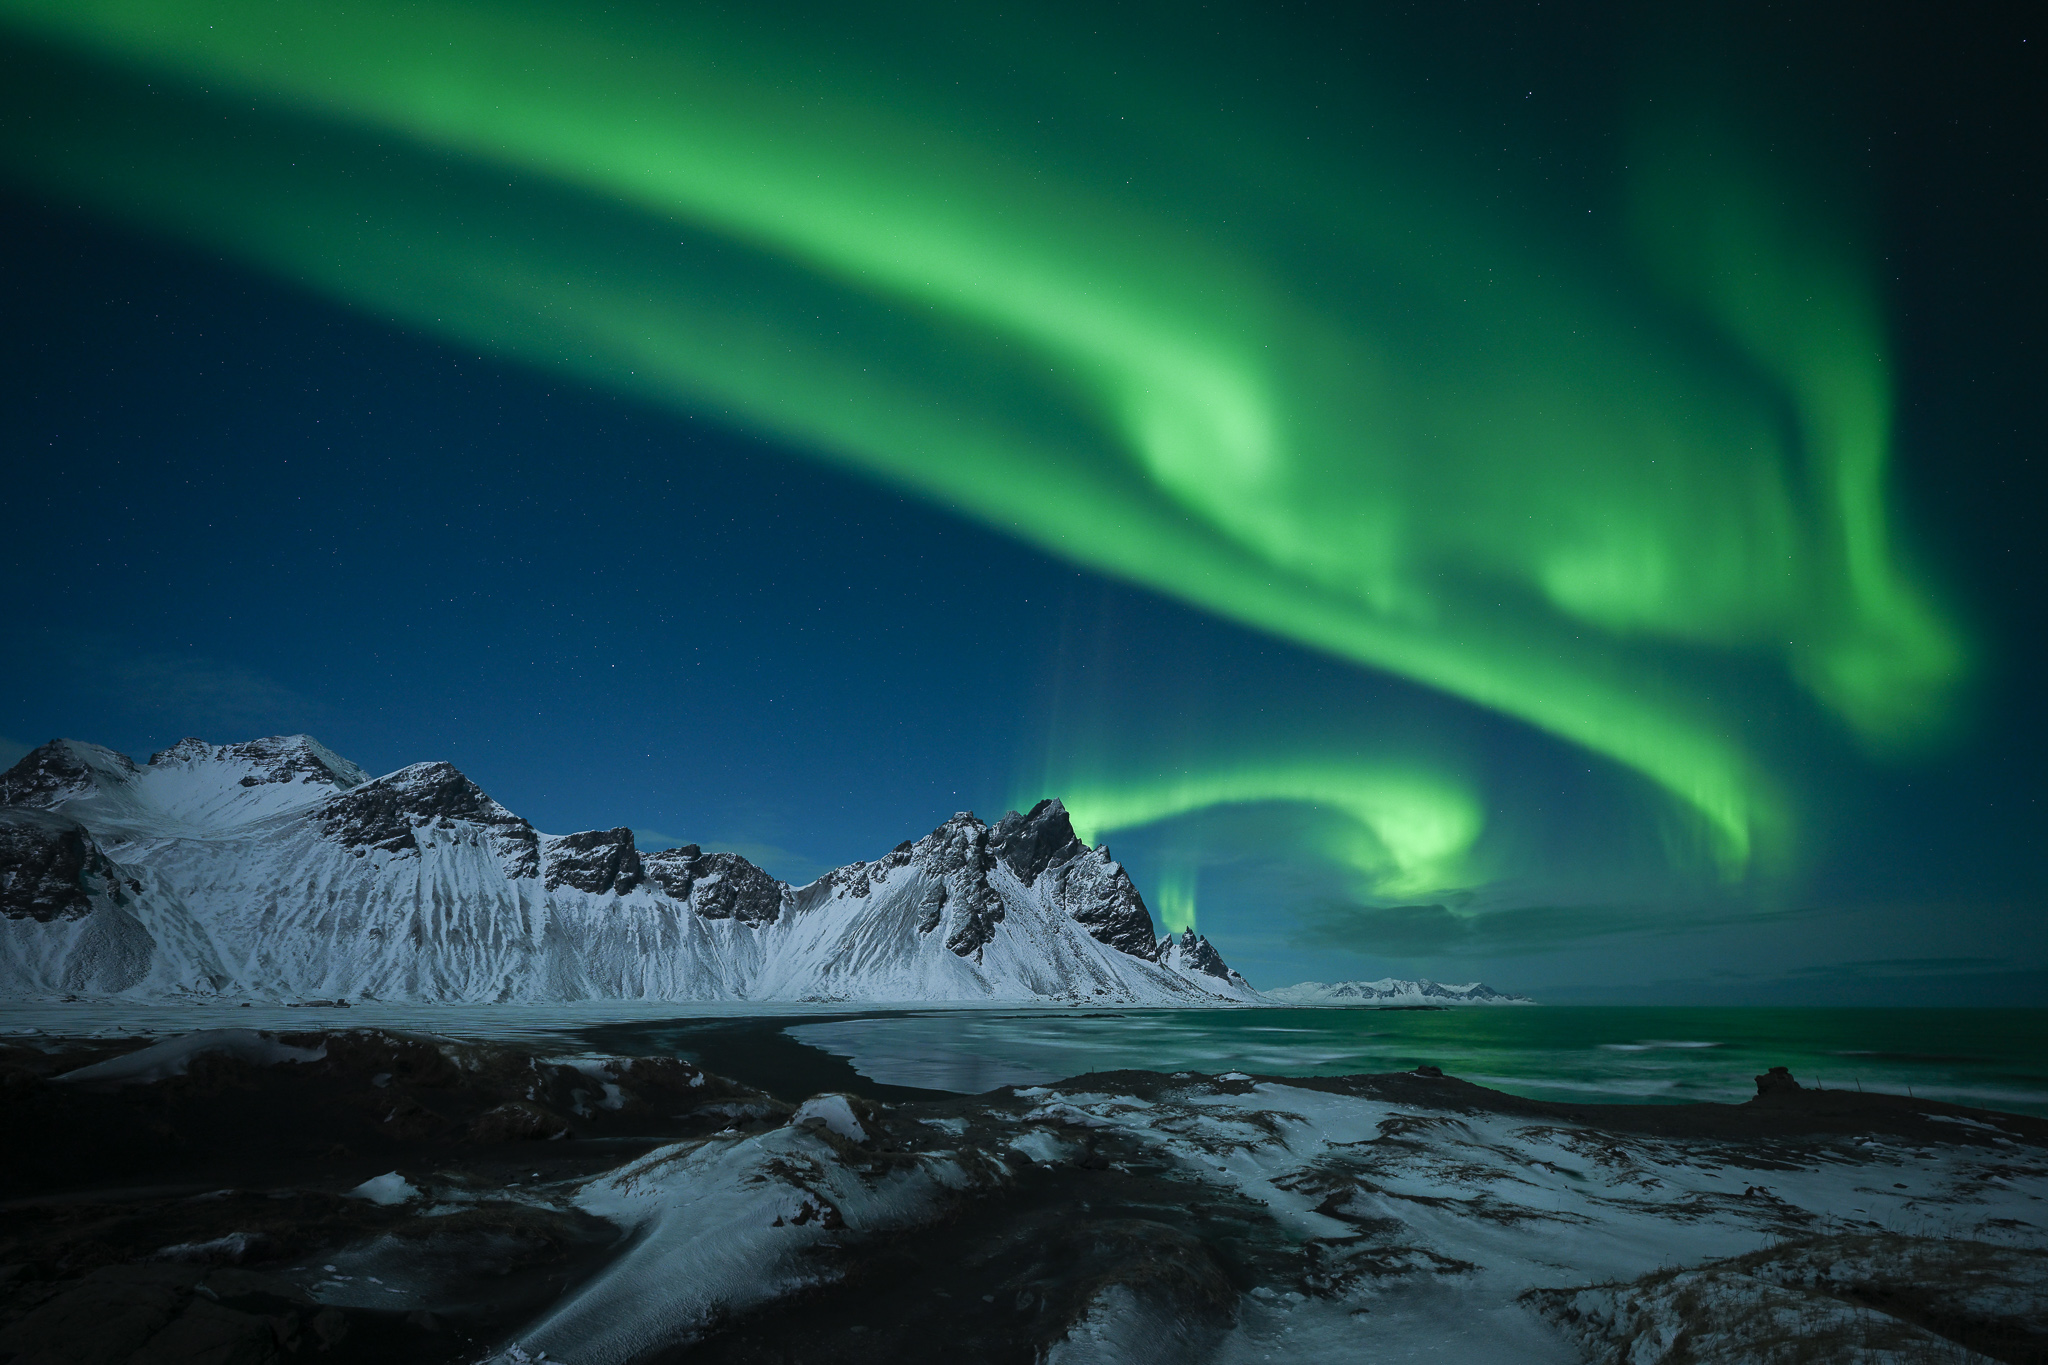

In [8]:
# test the class
from PIL import Image
import numpy as np
sample_image_path = "sample_image.jpg"
# show the image
Image.open(sample_image_path)

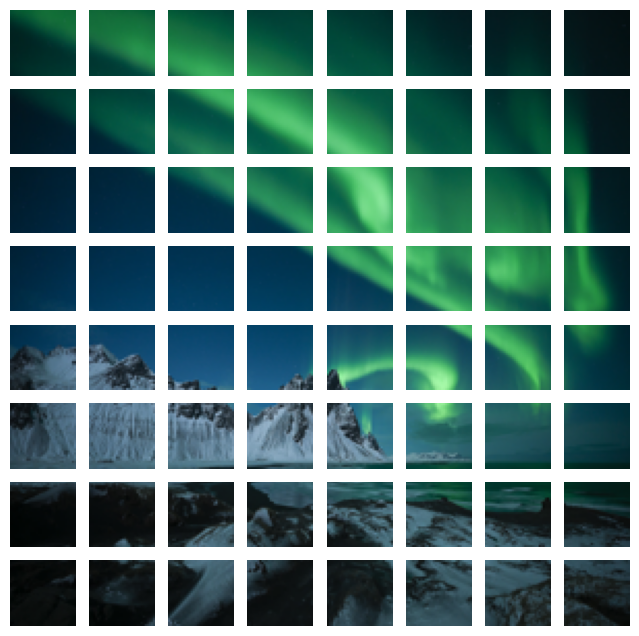

In [9]:
import matplotlib.pyplot as plt

# we will show the patches of the image
# Original image size: (2048, 1365)
# We will resize it to (256, 256)
# resized image will be cut down into 64 patches of 32x32
image_height, image_width = 256, 256
patch_height, patch_width = 32, 32

# Load and resize the image
image = Image.open(sample_image_path).resize((256, 256))
image_array = np.array(image)
# Cut down 64 patches of 32x32
patches = []
for i in range(0, image_height, patch_height):
  for j in range(0, image_width, patch_width):
    patch = image_array[i:i+patch_height, j:j+patch_width]
    patches.append(patch)

# Plot the patches in a grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for ax, patch in zip(axes.flatten(), patches):
  ax.imshow(patch)
  ax.axis('off')
plt.show()

In [10]:
# tensor level implementation

sample_image = Image.open(sample_image_path)
print(f"sample_image.size {sample_image.size}")

# resize the image to 256x256
sample_image = sample_image.resize((256, 256))
print(f"sample_image.size after resize: {sample_image.size}")
# convert the image to numpy array
sample_image = np.array(sample_image)
print(f"sample_image.shape after converting to numpy array: {sample_image.shape}")
# add batch dimension
sample_image = np.expand_dims(sample_image, axis=0)
print(f"sample_image.shape after adding batch dimension: {sample_image.shape}")
# convert the numpy array to tensor
sample_image = torch.tensor(sample_image, dtype=torch.float32).permute(0, 3, 1, 2)
print(f"sample_image.shape after converting to tensor and rearranging shape (b,c,h,w): {sample_image.shape}")

image_height, image_width = 256, 256 # As we have manually reseized the image to 256x256 in previous steps
# we will create patches of size 32x32 from the image, so we will have 64 patches in total (8x8)
patch_height, patch_width = 32,32 
# image dimension must be divisible by patch dimension
assert image_height % patch_height == 0, 'image height must be divisible by patch height'
num_patches = (image_height // patch_height) * (image_width // patch_width)
print(f"num_patches {num_patches}")

patch_dim = 3 * patch_height * patch_width # (c, h, w) = (3, 32, 32) = 3072
print(f"patch_dim {patch_dim}\n")

# Rearrange the image tensor to patches
print(f"sample image shape before converting to patches: {sample_image.shape}")

# Explanation of the rearrange function
# input shape: (b, c, h, w) -> output shape: (b, h, w, c)
# 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)'; 
# Left side: h is divided into (h p1) patches and w is divided into (w p2) patches
# for example: input(b,c,h,w):(1,3,256,256) -> (b,c,(h p1),(w p2)): (1,3 (8 32) (8 32))
# Right side: (b (h,w) (p1 p2 c)); (1,(8 8),(32 32 3)); (1,64,3072)
patches = rearrange(sample_image, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width)
print(f"patches.shape after rearranging (converting to patches): {patches.shape}")


sample_image.size (2048, 1365)
sample_image.size after resize: (256, 256)
sample_image.shape after converting to numpy array: (256, 256, 3)
sample_image.shape after adding batch dimension: (1, 256, 256, 3)
sample_image.shape after converting to tensor and rearranging shape (b,c,h,w): torch.Size([1, 3, 256, 256])
num_patches 64
patch_dim 3072

sample image shape before converting to patches: torch.Size([1, 3, 256, 256])
patches.shape after rearranging (converting to patches): torch.Size([1, 64, 3072])


## Vision Transformer Architecture

In [46]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        print(f"shape of pos_embedding: {self.pos_embedding.shape}") #[1, 65, 512] ; 65 = 64 patches + 1 cls token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        print("\n\n==============Transformer init=================\n\n")
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        print("\n\n==============Transformer init done============\n\n")

        self.pool = pool
        self.to_latent = nn.Identity()
        print(self.to_latent)
        
        # explanation of mlp_head
        # convert the output of transformer to the number of classes
        # dim is the model dimension of the transformer
        # num_classes is the number of classes specified by the user/like CIFAR10 has 10 classes
        
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        # convert the input image [1, 3, 256, 256] to patches [1, 64, 3072] and then use linear projection to convert it to [1, 64, 512]; 512 is the model dimension of the transformer
        print(f"shape of x after to_patch_embedding: {x.shape}")
        
        b, n, _ = x.shape

        # explanation of repeat function
        # repeat the cls_token to the batch size b; cls_token shape: (1, 1, 512) -> (b, 1, 512)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        print(f"shape of x after adding cls_token: {x.shape}") # (1, 65, 512)
        
        x += self.pos_embedding[:, :(n + 1)] # add position embedding; n+1 because we have added cls token
        x = self.dropout(x)

        print(f"shape of x after adding pos_embedding and dropout and before going into transformer: {x.shape}")
        x = self.transformer(x)
        print(f"\n\nshape of x after transformer: {x.shape}")

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        print(f"shape of x after mean pooling: {x.shape}")
        x = self.to_latent(x)
        print(f"shape of x after to_latent: {x.shape}")
        preds = self.mlp_head(x)
        print(f"shape of preds after mlp_head: {preds.shape}")
        return preds
  




In [48]:
# test the class
from PIL import Image
import numpy as np


sample_image_path = "sample_image.jpg"
sample_image = Image.open(sample_image_path)
sample_image = sample_image.resize((256, 256))
sample_image = np.array(sample_image)
sample_image = np.expand_dims(sample_image, axis=0)
sample_image = torch.tensor(sample_image, dtype=torch.float32).permute(0, 3, 1, 2)


print(f"sample_image.shape {sample_image.shape}") 
vit = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 10,# CIFAR10 has 10 classes for example
    dim = 512,
    depth = 1,
    heads = 8,
    mlp_dim = 1024,
    channels = 3,
    dim_head = 64,
    dropout = 0.1,
    emb_dropout = 0.1
)
preds = vit(sample_image) # (1, 1000)
print(preds)


sample_image.shape torch.Size([1, 3, 256, 256])
shape of pos_embedding: torch.Size([1, 65, 512])


==============Transformer init=================


self.heads 8
dim_head 64
inner_dim 512


Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=1024, bias=True)
  (2): GELU(approximate='none')
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): Dropout(p=0.1, inplace=False)
)


==============Transformer init done============


Identity()
shape of x after to_patch_embedding: torch.Size([1, 64, 512])
shape of x after adding cls_token: torch.Size([1, 65, 512])
shape of x after adding pos_embedding and dropout and before going into transformer: torch.Size([1, 65, 512])


==========Multi-Headed Attention Layer==========
 Input x.shape torch.Size([1, 65, 512])
 b: batch size 1
 n: number of tokens 65
 _: original dimension of input 512
 h: number of heads 8


 shape of qkv after 